In [1]:
### CHINCHILLA ###
import numpy as np

# a, b, e, alpha, beta = [6.007337896264272, 6.016157159698354, 0.5247285289349821, 0.34, 0.28] # MW
a, b, e, alpha, beta = [6.255414, 7.3049974, 0.6254804, 0.3526596, 0.3526596]

A = np.exp(a)
B = np.exp(b)
E = np.exp(e)
G = ((alpha*A)/(beta*B))**(1/(alpha+beta))

def optimal_N(C):
    a = (beta)/(alpha+beta)
    N_opt = G*(C/6)**a
    return N_opt

def N_to_C(N):
    a = (beta)/(alpha+beta)
    C = ((N/G) ** (1/a)) * 6
    return C
  
def optimal_D(C):
    b = (alpha)/(alpha+beta)
    D_opt = (1/G)*(C/6)**b
    return D_opt

def D_to_C(D):
    b = (alpha)/(alpha+beta)
    C = ((G*D) ** (1/b)) * 6
    return C

def loss_fn(N, D):
    L = E + A/(N**alpha) + B/(D**beta)
    return L


func = r"$L(N,D,EP,NP)=E + \frac{A}{(UN + UN * N^* * (1 - e^{(-1*NP/(N^*))}))^\alpha} + \frac{B}{(U + U * EP^* * (1 - e^{(-1*EP/(EP^*))}))^\beta}$"
params = [6.255414, 7.3049974, 0.6254804, 0.3526596, 0.3526596, 15.387756, 5.309743]

def scaling_law(N, D, U, params):
    a, b, e, alpha, beta, rd_star, rn_star  = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)

    RD = np.maximum((D / U) - 1, 0)    
    UN = np.minimum(N,optimal_N(D_to_C(U)))
    RN = np.maximum((N / UN ) - 1, 0)

    L = E + A/(UN + UN*rn_star*(1-np.exp(-1*RN/rn_star)))**alpha + B / (U + U * rd_star * (1 - np.exp(-1*RD/(rd_star))))**beta
    return L





GA FLOPs: 3.2436e+23
OPT FLOPs: 3.2436e+23


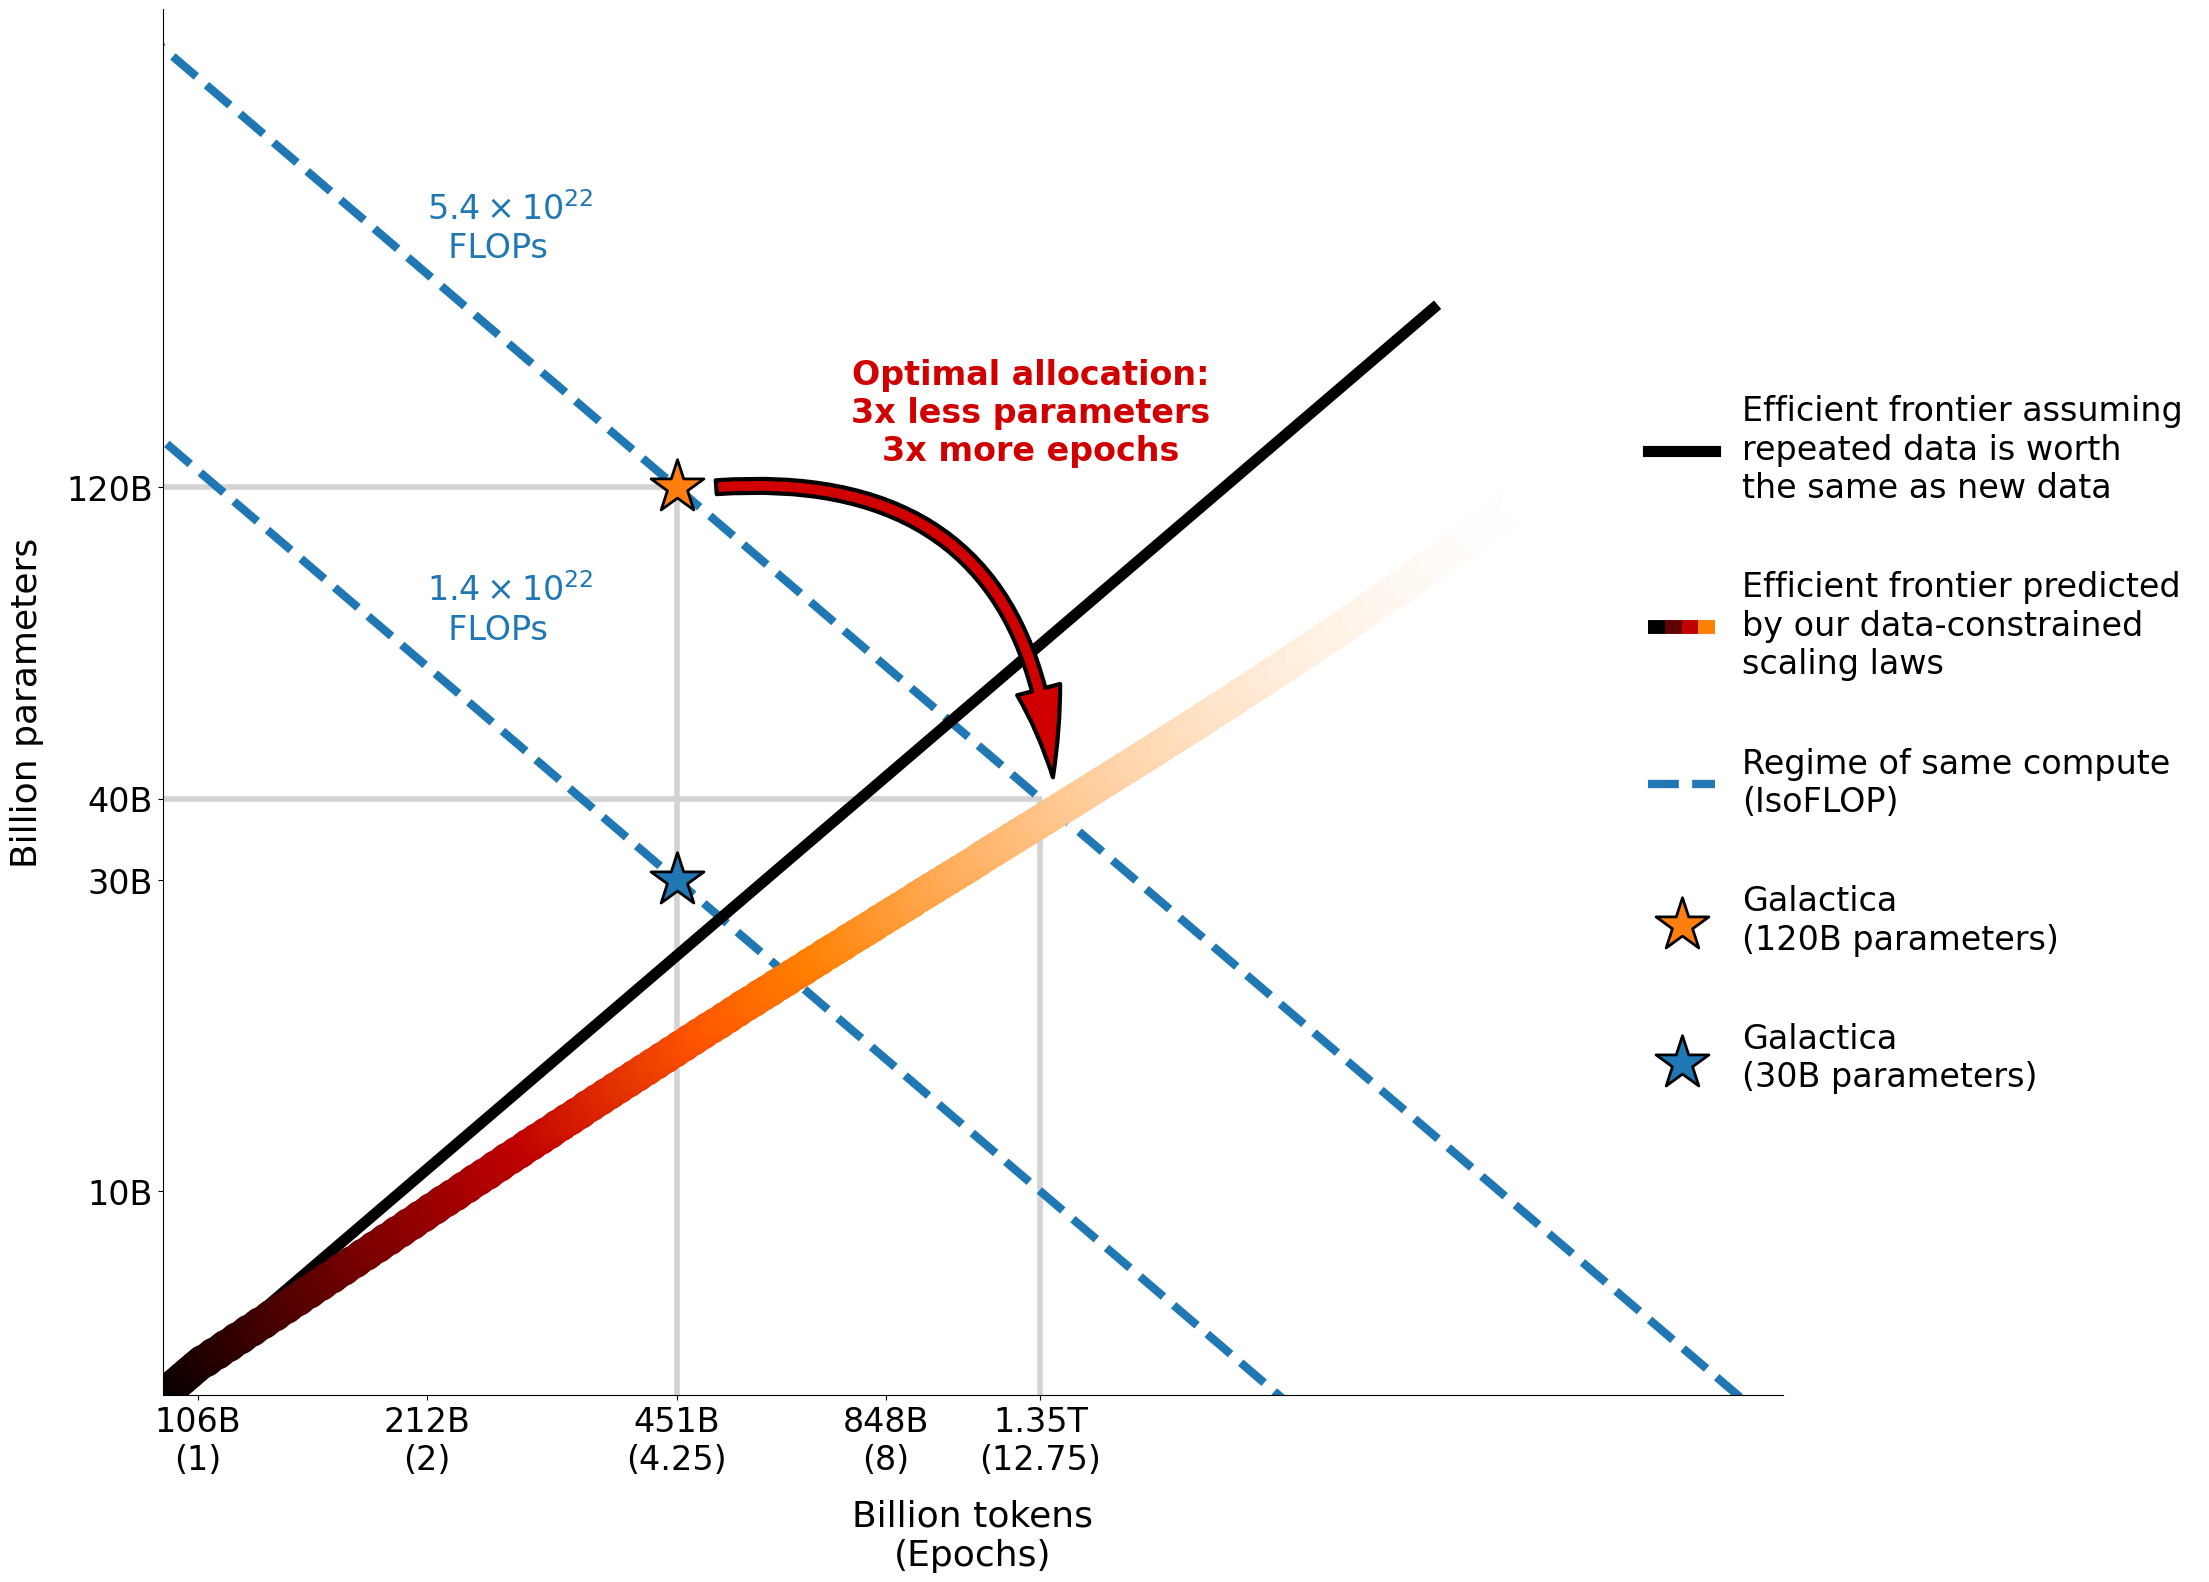

In [39]:
from matplotlib.cm import unregister_cmap
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.patches as patches

random.seed(42)
np.random.seed(42)

FONTSIZE = 24
FONTSIZE_SMALL = 16 + 2

fig, ax = plt.subplots(figsize=(24, 18), ncols=1)

UT = 106e9 # Galactice UT
P = optimal_N(D_to_C(UT))

"""
x_ticks = [100e5, 100e6, 100e7, 100e8, 100e9, 100e10, 100e11, 100e12]
x_ticks_str = ["10M", "100M", "1B", "10B", "100B", "1T", "10T", "100T"]
x_ticks = [x / UT for x in x_ticks]
ax.set_xticks(x_ticks, x_ticks_str)
"""

x_ticks = [UT, UT*2, UT*4.25, UT*8, 1351500000000.0]
x_ticks_str = ["106B\n(1)", "212B\n(2)", "451B\n(4.25)", "848B\n(8)", "1.35T\n(12.75)"]
x_ticks = [np.log10(x/UT) for x in x_ticks]
ax.set_xticks(x_ticks, x_ticks_str)
ax.set_xlim(np.log10(0.9), np.log10(120))


y_ticks = [100e5, 100e6, 100e7, 100e8, 100e9, 100e10, 100e11, 100e12, 120e9]
y_ticks_str = ["10M", "100M", "1B", "10B", "100B", "1T", "10T", "100T", "120B"]
y_ticks = [100e5, 100e6, 100e7, 100e8, 100e10, 100e11, 100e12, 120e9, 40e9, 30e9]
y_ticks_str = ["10M", "100M", "1B", "10B", "1T", "10T", "100T", "120B", "40B", "30B"]
y_ticks = [np.log10(x/P) for x in y_ticks]
ax.set_yticks(y_ticks, y_ticks_str)
ax.set_ylim(np.log10(0.9), np.log10(120))

ax.tick_params(labelsize=FONTSIZE)

MIN_PARAMS, MAX_PARAMS = 100e6, 1e12
MIN_TOKS, MAX_TOKS = 100e6, 1e12

f_min = MIN_PARAMS * MIN_TOKS * 6
f_max = MAX_PARAMS * MAX_TOKS * 6

c_c4 = np.logspace(np.log10(f_min), np.log10(f_max), 1500)
toks_c4 = np.log10(np.array([optimal_D(x)/UT for x in c_c4]))
size_c4 = np.log10(np.array([optimal_N(x)/P for x in c_c4]))

ax.plot(toks_c4, size_c4, label="Efficient frontier assuming\nrepeated data is worth\nthe same as new data", color="black", linestyle="-", linewidth=8.0)

##1f77b4
#ax.vlines(x=np.log10(base_e), ymin=-10, ymax=np.log10(base_p), color='lightgrey', zorder=-1, linestyle='-')
#ax.hlines(y=np.log10(base_p), xmin=-10, xmax=np.log10(base_e), color='lightgrey', zorder=-1, linestyle='-')

ax.vlines(x=np.log10(4.25), ymin=-10, ymax=np.log10(120e9/P), color='lightgrey', zorder=-1, linestyle='-', linewidth=4.0)
ax.vlines(x=np.log10(12.75), ymin=-10, ymax=np.log10(40e9/P), color='lightgrey', zorder=-1, linestyle='-', linewidth=4.0)

ax.hlines(y=np.log10(120e9/P), xmin=-10, xmax=np.log10(4.25), color='lightgrey', zorder=-1, linestyle='-', linewidth=4.0)
ax.hlines(y=np.log10(40e9/P), xmin=-10, xmax=np.log10(12.8), color='lightgrey', zorder=-1, linestyle='-', linewidth=4.0)


# Gridsearch for optimal values
toks_opt = []
size_opt = []
loss_opt = []

last_l = float("inf")
toks_c4 = np.array([optimal_D(x) for x in c_c4])
size_c4 = np.array([optimal_N(x) for x in c_c4])

start_t, end_t = ax.get_xlim()
start_s, end_s = ax.get_ylim()

for t, s in zip(toks_c4, size_c4):

    if not(start_t <= np.log10(t/UT) <= end_t) or not(start_s <= np.log10(s/P) <= end_s):
        continue

    min_l, min_t, min_s = scaling_law(s, t, min(UT, t), params), t, s
      
    for i in np.linspace(1.0001, 3, 500):
        D =  t*i
        U = min(UT, D)
        N = s/i

        new_l = scaling_law(N, D, U, params)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N

        D =  t/i
        U = min(UT, D)
        N = s*i
        
        new_l = scaling_law(N, D, U, params)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N
    
    if min_l >= last_l:
        print("Loss is not improving")
        break
    
    toks_opt.append(min_t / UT)
    size_opt.append(min_s / P)
    loss_opt.append(min_l)    

    last_l = min_l

ax.scatter(
    np.log10(toks_opt),
    np.log10(size_opt),
    s=256+128+128, 
    #color='black', 
    #label="Data-constrained Scaling Laws",
    c=loss_opt,
    cmap="gist_heat_r",
    zorder=2,
    #edgecolor="black",
    #linewidth=0.2,
)

ax.plot(
    [],#np.log10([t for t,l in zip(toks_opt, loss_opt) if not(Z.min() <= l <= Z.min() + 1)]),
    [],#np.log10([s for s,l in zip(size_opt, loss_opt) if not(Z.min() <= l <= Z.min() + 1)]),
    #s=128, 
    color='black', 
    label="Efficient frontier predicted\nby our data-constrained\nscaling laws",
    #c=[l for l in loss_opt if not(Z.min() <= l <= Z.min() + 1)],
    #cmap=outer_cmap,#contours.cmap,
    #zorder=2,
    #edgecolor="black",
    linewidth=10,
)

#"""

#"""
#"""
ax.annotate(
    r'$5.4 \times 10^{22}$' + '\n  FLOPs', 
    xy=(np.log10(2), np.log10(4)), 
    #xy=(np.log10(55e9 * 6), 2.21), 
    #xycoords='data',
    xytext=(np.log10(2), np.log10(50)),
    #xytext=(np.log10(10**12), 2.25), 
    textcoords='data',
    #va='top', ha='left',
    fontsize=FONTSIZE,
    color="#1f77b4",
    #fontweight="bold",
    #arrowprops=dict(facecolor='black', shrink=0.05, width=2.5)
)

ax.annotate(
    r'$1.4 \times 10^{22}$' + '\n  FLOPs', 
    xy=(np.log10(2), np.log10(3)), 
    #xy=(np.log10(55e9 * 6), 2.21), 
    #xycoords='data',
    xytext=(np.log10(2), np.log10(13)),
    #xytext=(np.log10(10**12), 2.25), 
    textcoords='data',
    #va='top', ha='left',
    fontsize=FONTSIZE,
    color="#1f77b4",
    #fontweight="bold",
    #arrowprops=dict(facecolor='black', shrink=0.05, width=2.5)
)
#"""

# Galactica
ut_g = 106e9
ep_g = 4.25
t_g = ep_g * ut_g

params_g = [125e6, 1.3e9, 6.7e9, 30e9, 120e9][3:]
params_g_str = ["125M", "1.3B", "6.7B", "30B", "120B"][3:]
for p_g, p_g_str in zip(params_g, params_g_str):
    #mp_g, dm_g, _ = get_vals(p_g, t_g, ut_g, 0)
    ax.scatter([np.log10(ep_g)], [np.log10(p_g / P)], s=1600, linewidth=2.0, marker='*', zorder=10, edgecolor="black", label=f"Galactica\n({p_g_str} parameters)")

ax.plot(
    [np.log10(ep_g*0.01), np.log10(ep_g), np.log10(ep_g*100)],
    [np.log10((120e9/P)*100), np.log10((120e9/P)), np.log10((120e9/P)*0.01)], 
    linewidth=6.0,
    label="Regime of same compute\n(IsoFLOP)",
    linestyle="--",
    color="#1f77b4",
    zorder=1
)

ax.plot(
    [np.log10(ep_g*0.01), np.log10(ep_g), np.log10(ep_g*100)],
    [np.log10((30e9/P)*100), np.log10((30e9/P)), np.log10((30e9/P)*0.01)], 
    linewidth=6.0,
    #label="Regime of same compute (IsoFLOP)",
    linestyle="--",
    color="#1f77b4",
    zorder=1
)

# https://stackoverflow.com/questions/44526103/matplotlib-draw-curved-arrow-that-looks-just-like-pyplot-arrow
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
style = "Simple, tail_width=10, head_width=32, head_length=64"
kw = dict(arrowstyle=style)

#y_s, y_e = ax.get_ylim()


unique_toks = ut_g
t = t_g
s = 120e9
min_l = 12e9
for i in np.linspace(1.0001, 3, 500):
    D =  t*i
    U = min(unique_toks, D)
    N = s/i

    new_l = scaling_law(N, D, U, params)
    if new_l < min_l:
        min_l, min_t, min_s = new_l, D, N

    D =  t/i
    U = min(unique_toks, D)
    N = s*i

    new_l = scaling_law(N, D, U, params)
    if new_l < min_l:
        min_l, min_t, min_s = new_l, D, N


print("GA FLOPs:", 120e9 * t_g * 6)
print("OPT FLOPs:", min_s * min_t * 6)

gal_exp_loss = scaling_law(120e9, t_g, 106e9, params)
opt_exp_loss = scaling_law(min_s, min_t, 106e9, params)


a3 = patches.FancyArrowPatch(
    (np.log10(ep_g + 0.5), np.log10(120e9/P)), (np.log10(min_t / ut_g + 0.5), np.log10(min_s/P + 0.5)),
    connectionstyle="arc3,rad=-.5", 
    transform=ax.transData,
    #linestyle='dashed',
    #dashes=(5, 15),
    edgecolor="black",
    facecolor="#D00000",
    linewidth=3,
    zorder=20,
    **kw
)
ax.add_patch(a3)



diff = round((1 - (opt_exp_loss / gal_exp_loss)) * 100)

ax.annotate(
    #f'{diff}% predicted\nloss reduction', 
#    '3x' + r'$\bf{less}$' + 'parameters' + '\n' + r'3x $\bf{more}$ epochs', 
#    r'$\mathbf{\mathit{BOLD\ AND\ ITALICS\ PART}}$' + r'$\mathbf{BOLD\ ONLY}$',
    'Optimal allocation:\n3x less parameters\n3x more epochs',
    xy=(np.log10(2), np.log10(3.1)), 
    #xy=(np.log10(55e9 * 6), 2.21), 
    #xycoords='data',
    xytext=(np.log10(min_t*0.97 / ut_g), np.log10(min_s*3.3/P)),
    #xytext=(np.log10(10**12), 2.25), 
    textcoords='data',
    #va='top', ha='left',
    ha='center',
    fontsize=FONTSIZE,
    color="#D00000",
    fontweight="bold",
    #arrowprops=dict(facecolor='black', shrink=0.05, width=2.5)
)


# Reorder
order = [
    "Efficient frontier assuming\nrepeated data is worth\nthe same as new data", 
    "Efficient frontier predicted\nby our data-constrained\nscaling laws",     
    "Regime of same compute\n(IsoFLOP)", 
    'Galactica\n(120B parameters)',  
    'Galactica\n(30B parameters)',  
]

handles, labels = ax.get_legend_handles_labels()
handles_ordered, labels_ordered = [], []

for o in order:
    for h, l in zip(handles, labels):
        if l == "Efficient frontier predicted\nby our data-constrained\nscaling laws":
            to_map = h
        if l == o:
            handles_ordered.append(h)
            labels_ordered.append(l)

handles, labels = handles_ordered, labels_ordered


from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
# Make handles with gradient as well, but black seems fine
# https://stackoverflow.com/questions/49223702/adding-a-legend-to-a-matplotlib-plot-with-a-multicolored-line
class HandlerColorLineCollection(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='gist_heat',
                     transform=trans)
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]

# https://stackoverflow.com/questions/31478077/how-to-make-two-markers-share-the-same-label-in-the-legend-using-matplotlib
from matplotlib.legend_handler import HandlerTuple
legend = fig.legend(
    handles, 
    labels, 
    loc=(0.74,0.3),#"lower center",#(0,-0.3), 
    ncol=1, 
    frameon=False, 
    fontsize=FONTSIZE,
    handler_map={to_map: HandlerColorLineCollection(numpoints=4), tuple: HandlerTuple(ndivide=None)},
    labelspacing=2,
)

#plt.subplots_adjust(wspace=0.3, bottom=0.3)#, right=0.9)
plt.subplots_adjust(right=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Billion tokens\n(Epochs)', fontsize=FONTSIZE+2, labelpad=16)
ax.set_ylabel("Billion parameters", fontsize=FONTSIZE+2, labelpad=16)

plt.savefig(f"galactica.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"galactica.png", bbox_inches="tight", dpi=300)

plt.show()

